#NIFTY 50 : ITC STOCK PRICE PREDICTION
Final Assignment/Project for "Deep Learning: Zero to GANs" course by Medha Mathur.


In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np
import datetime as dt
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout

In [5]:
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [6]:
project_name='nifty-50-stock-price-prediction-itc'

Dataset taken from :

https://in.finance.yahoo.com/quote/ITC.NS/history?period1=1262304000&period2=1609977600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

The .csv file has been imported in the from Google Sheets. 

In [7]:
!pip install jovian --upgrade -q

In [8]:
import jovian

In [9]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/medhamathur27/nifty-50-stock-price-prediction-itc


'https://jovian.ai/medhamathur27/nifty-50-stock-price-prediction-itc'

In [10]:
!pip install --upgrade gspread

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [12]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [13]:
worksheet = gc.open('ITC.csv').sheet1
rows = worksheet.get_all_values()
dataset_raw = pd.DataFrame(rows[1:],columns=rows[0])
dataset_raw.dropna()
dataset_raw.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,84.333298,85,83.449997,84.550003,62.131336,5161635
1,2010-01-05,84.933296,85.583298,84.233299,85.383301,62.74369,10767225
2,2010-01-06,86.233299,86.233299,84.533302,85.583298,62.890656,7529979
3,2010-01-07,85.666702,86.166702,84.566704,85.316704,62.694752,4987434
4,2010-01-08,85.116699,86.166702,85.116699,85.5,62.829453,4881351


In [14]:
dataset_raw.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2718,2020-12-30,212.699997,213.5,209.550003,211.149994,211.149994,18925262
2719,2020-12-31,210.550003,211.300003,208.550003,209,209,18245270
2720,2021-01-01,209.899994,214.199997,209.300003,213.850006,213.850006,19527333
2721,2021-01-04,214,216,212.100006,213.399994,213.399994,26891799
2722,2021-01-05,212.449997,213.25,210.600006,211.449997,211.449997,18024083


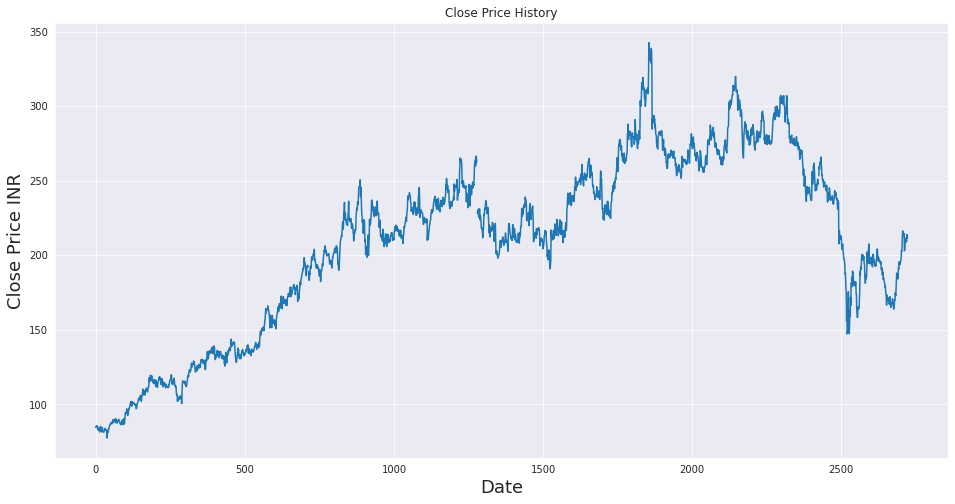

In [15]:
#Visualizing the closing price history for the training dataset
close_price = pd.to_numeric(dataset_raw['Close'], errors='coerce')
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(close_price)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price INR',fontsize=18)
plt.show()


In [16]:
features = ["Date", "Close"]
dataset = dataset_raw[features]

In [17]:
#setting index
dataset.index = dataset.Date
dataset.drop('Date', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [18]:
dataset.head()

,Close
Date,
2010-01-04,84.550003
2010-01-05,85.383301
2010-01-06,85.583298
2010-01-07,85.316704
2010-01-08,85.5


In [19]:
dataset['Close'] = close_price.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
dataset['Close'] = dataset['Close'].fillna(0)
dataset=dataset[dataset['Close'] != 0]

In [22]:
dataset.shape

(2714, 1)

#Preparing the dataset for Training

In [23]:
dataset_final = dataset.values
train_ds = dataset_final[0:1714,:]
valid_ds = dataset_final[1714:,:]

In [24]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset_final)

Creating Sliding Window of 90 days

In [25]:
x_train, y_train = [], []
for i in range(90,len(train_ds)):
    x_train.append(scaled_data[i-90:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [26]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [27]:
assert not np.any(np.isnan(x_train))

Model Building

In [39]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1),activation="relu"))
model.add(Dropout(rate = 0.001))

model.add(LSTM(units=50, return_sequences = True,activation="relu"))
model.add(Dropout(rate = 0.001))

model.add(LSTM(units=50, return_sequences = True,activation="relu"))
model.add(Dropout(rate = 0.001))

model.add(LSTM(units=50, return_sequences = False,activation="relu"))
model.add(Dropout(rate = 0.001))

model.add(Dense(1))

In [40]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [41]:
model.fit(x_train, y_train, epochs=25, batch_size=64)

Epoch 1/25
26/26 [==============================] - 9s 191ms/step - loss: 0.1529
Epoch 2/25
26/26 [==============================] - 5s 193ms/step - loss: 0.0088
Epoch 3/25
26/26 [==============================] - 5s 197ms/step - loss: 0.0017
Epoch 4/25
26/26 [==============================] - 5s 195ms/step - loss: 0.0013
Epoch 5/25
26/26 [==============================] - 5s 196ms/step - loss: 0.0011
Epoch 6/25
26/26 [==============================] - 5s 196ms/step - loss: 0.0011
Epoch 7/25
26/26 [==============================] - 5s 193ms/step - loss: 0.0011
Epoch 8/25
26/26 [==============================] - 5s 194ms/step - loss: 0.0011
Epoch 9/25
26/26 [==============================] - 5s 194ms/step - loss: 0.0013
Epoch 10/25
26/26 [==============================] - 5s 190ms/step - loss: 0.0011
Epoch 11/25
26/26 [==============================] - 5s 196ms/step - loss: 0.0011
Epoch 12/25
26/26 [==============================] - 5s 195ms/step - loss: 0.0011
Epoch 13/25
26/26 [======

In [42]:
model.fit(x_train, y_train, epochs=25, batch_size=55)

Epoch 1/25
30/30 [==============================] - 6s 183ms/step - loss: 9.6567e-04
Epoch 2/25
30/30 [==============================] - 6s 187ms/step - loss: 8.9179e-04
Epoch 3/25
30/30 [==============================] - 6s 186ms/step - loss: 8.7675e-04
Epoch 4/25
30/30 [==============================] - 6s 188ms/step - loss: 8.8600e-04
Epoch 5/25
30/30 [==============================] - 6s 186ms/step - loss: 8.7009e-04
Epoch 6/25
30/30 [==============================] - 6s 187ms/step - loss: 8.1952e-04
Epoch 7/25
30/30 [==============================] - 6s 188ms/step - loss: 7.2205e-04
Epoch 8/25
30/30 [==============================] - 6s 188ms/step - loss: 7.0576e-04
Epoch 9/25
30/30 [==============================] - 6s 184ms/step - loss: 6.8359e-04
Epoch 10/25
30/30 [==============================] - 5s 183ms/step - loss: 6.4660e-04
Epoch 11/25
30/30 [==============================] - 6s 185ms/step - loss: 6.7752e-04
Epoch 12/25
30/30 [==============================] - 6s 185ms/s

In [43]:
model.fit(x_train, y_train, epochs=25, batch_size=55)

Epoch 1/25
30/30 [==============================] - 5s 183ms/step - loss: 4.7268e-04
Epoch 2/25
30/30 [==============================] - 6s 183ms/step - loss: 4.5178e-04
Epoch 3/25
30/30 [==============================] - 6s 183ms/step - loss: 4.3124e-04
Epoch 4/25
30/30 [==============================] - 5s 182ms/step - loss: 4.1473e-04
Epoch 5/25
30/30 [==============================] - 6s 184ms/step - loss: 4.7687e-04
Epoch 6/25
30/30 [==============================] - 6s 187ms/step - loss: 4.3426e-04
Epoch 7/25
30/30 [==============================] - 5s 182ms/step - loss: 3.9864e-04
Epoch 8/25
30/30 [==============================] - 5s 182ms/step - loss: 4.4041e-04
Epoch 9/25
30/30 [==============================] - 5s 182ms/step - loss: 3.6037e-04
Epoch 10/25
30/30 [==============================] - 6s 185ms/step - loss: 3.9664e-04
Epoch 11/25
30/30 [==============================] - 6s 190ms/step - loss: 4.2285e-04
Epoch 12/25
30/30 [==============================] - 6s 190ms/s

In [44]:
#predicting test data values, using past 90 from the train data
inputs = dataset[len(dataset) - len(valid_ds)-90:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [45]:
inputs.shape

(1090, 1)

In [46]:
X_test = []
for i in range(90,inputs.shape[0]):
    X_test.append(inputs[i-90:i,0])
X_test = np.array(X_test)

In [47]:
X_test

array([[0.66123855, 0.65897514, 0.66067271, ..., 0.59691913, 0.58748813,
        0.57447337],
       [0.65897514, 0.66067271, 0.65086445, ..., 0.58748813, 0.57447337,
        0.56183586],
       [0.66067271, 0.65086445, 0.64218792, ..., 0.57447337, 0.56183586,
        0.5642879 ],
       ...,
       [0.4499842 , 0.44508007, 0.4433825 , ..., 0.50600435, 0.50449535,
        0.49638472],
       [0.44508007, 0.4433825 , 0.44074183, ..., 0.50449535, 0.49638472,
        0.51468088],
       [0.4433825 , 0.44074183, 0.44564596, ..., 0.49638472, 0.51468088,
        0.51298325]])

In [48]:
X_test.shape

(1000, 90)

In [49]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds)

In [50]:
X_test.shape

(1000, 90, 1)

In [51]:
preds

array([[233.28535],
       [230.76018],
       [228.58582],
       [228.02614],
       [227.41026],
       [227.06387],
       [226.26564],
       [225.50648],
       [227.36017],
       [230.51099],
       [233.38275],
       [236.72247],
       [239.32722],
       [241.40718],
       [243.28407],
       [244.89601],
       [244.74985],
       [244.61732],
       [245.50838],
       [246.13759],
       [245.44879],
       [245.80609],
       [246.37822],
       [247.62798],
       [248.49405],
       [249.7794 ],
       [251.26045],
       [253.41583],
       [255.28802],
       [257.74966],
       [257.73926],
       [256.2998 ],
       [255.52695],
       [258.32138],
       [262.54977],
       [265.58936],
       [267.857  ],
       [269.6485 ],
       [270.3384 ],
       [271.09622],
       [270.6246 ],
       [269.07523],
       [267.82642],
       [267.9841 ],
       [266.40182],
       [265.15585],
       [263.9614 ],
       [262.25345],
       [261.1025 ],
       [261.3038 ],


In [52]:
rms=np.sqrt(np.mean(np.power((valid_ds-preds),2)))
rms

6.492920558751342

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


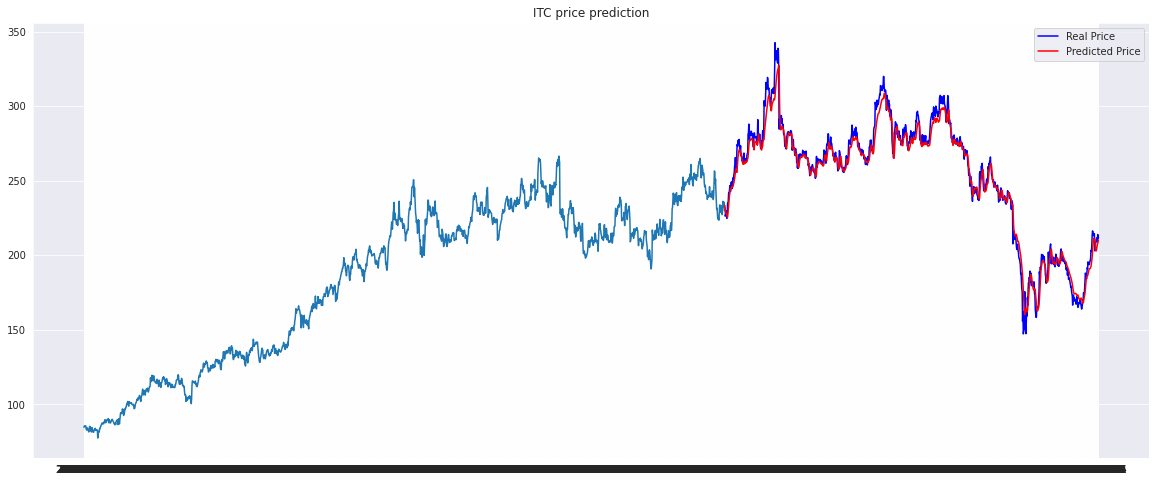

In [67]:
#for plotting
train = dataset[0:1714]
valid = dataset[1714:]
valid['Predictions'] = preds
plt.figure(figsize=(20,8))
plt.plot(train['Close'])
plt.plot(valid['Close'], color = 'blue', label = 'Real Price')
plt.plot(valid['Predictions'], color = 'red', label = 'Predicted Price')
plt.title('ITC price prediction')
plt.legend()
plt.show()

#Predicting future value of stock

In [68]:
look_back=15
inputs = dataset[-look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [69]:
forecast_list=[]
for _ in range(30):
  x = inputs[-look_back:]
  x = np.reshape(x, (x.shape[1],x.shape[0],1))
  forecast = model.predict(x)
  forecast = scaler.inverse_transform(forecast)
  inputs = scaler.inverse_transform(inputs)
  inputs = np.append(inputs,forecast[0][0])
  inputs = inputs.reshape(-1,1)
  inputs  = scaler.transform(inputs)
  forecast_list.append(forecast[0][0])

In [70]:
last_date = dataset_raw['Date'].values[-1]
prediction_dates = pd.date_range(last_date, periods=31).tolist()
prediction_dates = prediction_dates[1:]
prediction_dates

[Timestamp('2021-01-06 00:00:00', freq='D'),
 Timestamp('2021-01-07 00:00:00', freq='D'),
 Timestamp('2021-01-08 00:00:00', freq='D'),
 Timestamp('2021-01-09 00:00:00', freq='D'),
 Timestamp('2021-01-10 00:00:00', freq='D'),
 Timestamp('2021-01-11 00:00:00', freq='D'),
 Timestamp('2021-01-12 00:00:00', freq='D'),
 Timestamp('2021-01-13 00:00:00', freq='D'),
 Timestamp('2021-01-14 00:00:00', freq='D'),
 Timestamp('2021-01-15 00:00:00', freq='D'),
 Timestamp('2021-01-16 00:00:00', freq='D'),
 Timestamp('2021-01-17 00:00:00', freq='D'),
 Timestamp('2021-01-18 00:00:00', freq='D'),
 Timestamp('2021-01-19 00:00:00', freq='D'),
 Timestamp('2021-01-20 00:00:00', freq='D'),
 Timestamp('2021-01-21 00:00:00', freq='D'),
 Timestamp('2021-01-22 00:00:00', freq='D'),
 Timestamp('2021-01-23 00:00:00', freq='D'),
 Timestamp('2021-01-24 00:00:00', freq='D'),
 Timestamp('2021-01-25 00:00:00', freq='D'),
 Timestamp('2021-01-26 00:00:00', freq='D'),
 Timestamp('2021-01-27 00:00:00', freq='D'),
 Timestamp

In [71]:
fpred=pd.DataFrame(list(zip(prediction_dates, forecast_list)), 
               columns =['Date', 'Predicted Close']) 
fpred

,Date,Predicted Close
0,2021-01-06,197.195343
1,2021-01-07,196.367004
2,2021-01-08,194.470108
3,2021-01-09,192.162552
4,2021-01-10,188.482712
5,2021-01-11,184.903610
6,2021-01-12,181.319778
7,2021-01-13,177.623230
8,2021-01-14,173.854446
9,2021-01-15,170.000397


<Figure size 648x360 with 0 Axes>

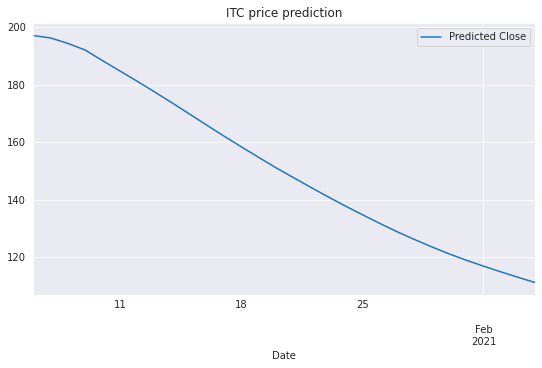

In [72]:
plt.figure(figsize=(9,5))
fpred.plot(x='Date',label = 'Predicted Price')
plt.title('ITC price prediction')
plt.legend()
plt.show()

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/medhamathur27/nifty-50-stock-price-prediction-02


'https://jovian.ai/medhamathur27/nifty-50-stock-price-prediction-02'